In [1]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
bnc = ccxt.binance()
from matplotlib.pyplot import figure

In [2]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    coinFrames = pd.DataFrame(dataframes[0][["close","volume"]]).rename(columns={'close':"".join(['BTC_',"CLOSE"]),'volume':"".join(['BTC_',"VOL"])})
    for i,coin in enumerate(labels[1:]):
        temp_frame = pd.DataFrame(dataframes[i+1]["close","volume"]).rename(columns={'close':"".join(coin,"CLOSE"),'volume':"".join(coin,"VOL")})
        coinFrames = coinFrames.merge(temp_opens,how='outer',on='timestamp')
    return (coinFrames)

def load_crypto(days=1000,n=30,timeframe='1h'):
    bnc = ccxt.binance()
    #symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    symbols = ['BTC']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60*24):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,pd.to_datetime(since,unit='ms'))
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i+1,:]/price_arr[i,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i+1,:]/price_arr[i,:])
    log_returns_df = pd.DataFrame(log_returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

def proc_ccxt_timestamps(df: object) -> object:
    df.index = pd.to_datetime(df.index,unit='ms')
    return df


In [3]:
#loads and writes the data to csv
#opens=load_crypto(days=1500,timeframe='1d')
#opens.to_csv('BitcoinData')

In [4]:
#loads bitcoin price and volume data and creates appropriate vectors
df = pd.read_csv('BTC_data').set_index("timestamp")
df = proc_ccxt_timestamps(df.dropna(axis=0))

#loads number of bitcoins and processes timestamps
numcoins = pd.read_csv('BTC_numcoins.csv').set_index("Timestamp")
numcoins.index = numcoins.index.rename('timestamp')
numcoins.index = pd.to_datetime(numcoins.index)
numcoins.index = numcoins.index.round('D')

#merges with price data
df = df.merge(numcoins,how='left',on='timestamp')
df = df.fillna(method='bfill')
df['pct_cap'] = df.BTC_VOL/df["total-bitcoins"]

#loads SP500 data
sp = pd.read_csv('SP500_data.csv').set_index("Date")
sp.index = sp.index.rename('timestamp')
sp.index = pd.to_datetime(sp.index)
sp.index = sp.index.round('D')

#merge SP500 on btc table
sp = df.merge(sp,how='left',on='timestamp')
sp.Volume = sp.Volume.fillna(0) #fills empty volumes with 0, not bfill
sp = sp.fillna(method='bfill')
sp = sp.fillna(method='ffill')
sp.Close = pd.to_numeric(sp.Close)
sp.Volume = pd.to_numeric(sp.Volume)
sp["Market_Cap"] = sp.Close*8.6e9
sp["pct"] = sp.Volume/sp.Market_Cap

In [5]:
btc_returns = get_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_logr = get_log_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_lrsq = ((btc_logr)**2)
btc_vol = df.BTC_VOL.iloc[1:].values
btc_pct = df.pct_cap[1:].values
btc_r_pct = np.nan_to_num((btc_returns-1)/btc_pct)
btc_lrsq_pct = np.nan_to_num(btc_lrsq/btc_pct)

sp_returns = get_returns(pd.DataFrame(sp.Close)).Close.values
sp_logr = get_log_returns(pd.DataFrame(sp.Close)).Close.values
sp_lrsq = ((sp_logr)**2)
sp_vol = sp.Volume.iloc[1:].values
sp_pct = sp.pct[1:].values
sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/1722435563.py:14: RuntimeWarning: divide by zero encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/1722435563.py:14: RuntimeWarning: invalid value encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/1722435563.py:15: RuntimeWarning: divide by zero encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/1722435563.py:15: RuntimeWarning: invalid value encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)


/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/3982049165.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/3982049165.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)


(0.0, 25.0)

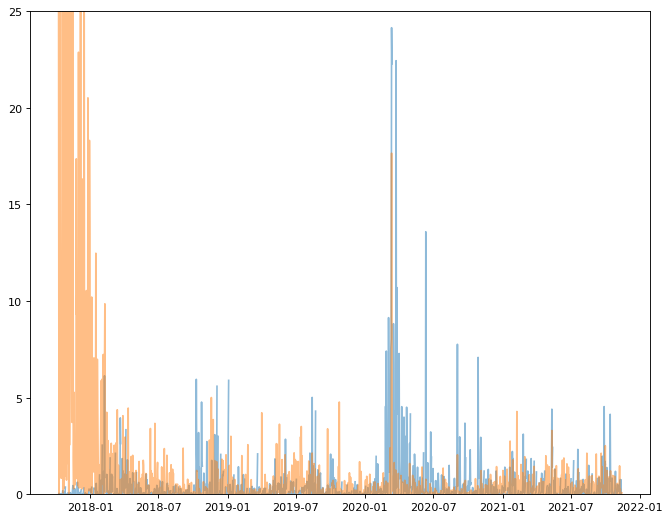

In [6]:
figure(figsize=(10, 8), dpi=80)
plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)
plt.plot(sp.index[1:],btc_lrsq/btc_pct,alpha=.5)
plt.ylim((0,25))

1


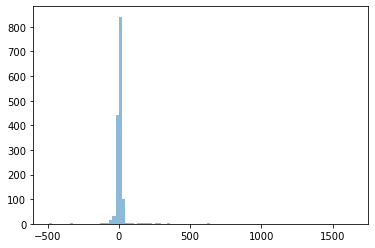

In [7]:
plt.hist(btc_r_pct,bins=100,alpha=.5)
#plt.hist(sp_r_pct,bins=100,alpha=.5)
print("1")

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/2528540173.py:1: RuntimeWarning: divide by zero encountered in true_divide
  sp_x = sp_lrsq/sp_pct
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/2528540173.py:1: RuntimeWarning: invalid value encountered in true_divide
  sp_x = sp_lrsq/sp_pct


1


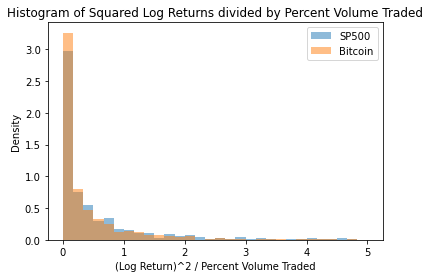

In [8]:
sp_x = sp_lrsq/sp_pct
btc_x = btc_lrsq/btc_pct
sp_x[np.isnan(sp_x)] = 0
sp_x[np.isinf(sp_x)] = 0
plt.hist(sp_x,bins=30,alpha=.5,range=(0.00001,5),density=True,label="SP500")
plt.hist(btc_x,bins=30,alpha=.5,range=(0.00001,5),density=True,label="Bitcoin")
plt.xlabel("(Log Return)^2 / Percent Volume Traded")
plt.ylabel("Density")
plt.title("Histogram of Squared Log Returns divided by Percent Volume Traded")
plt.legend()
print('1')

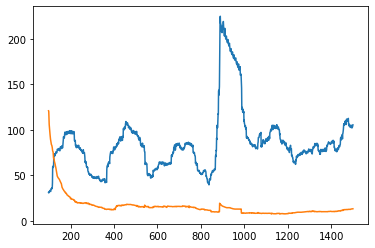

In [9]:
plt.plot(pd.DataFrame(sp_logr).rolling(100).std()/pd.DataFrame(sp_pct).rolling(100).mean())
plt.plot(pd.DataFrame(btc_logr).rolling(100).std()/pd.DataFrame(btc_pct).rolling(100).mean())

(0.0, 5.0)

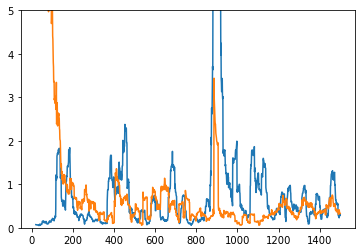

In [10]:
plt.plot(pd.DataFrame(sp_lrsq).rolling(21).mean()/pd.DataFrame(sp_pct).rolling(21).mean())
plt.plot(pd.DataFrame(btc_lrsq).rolling(21).mean()/pd.DataFrame(btc_pct).rolling(21).mean())
plt.ylim((0,5))

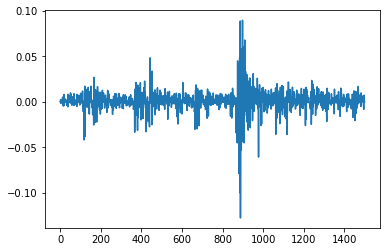

In [11]:
plt.plot(sp_logr)

### Looking for evidence of volatility clustering 

<AxesSubplot:>

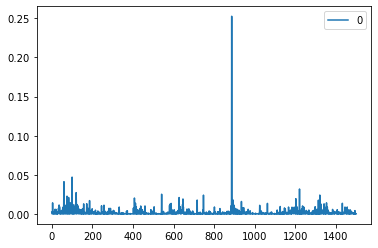

In [12]:
pd.DataFrame(btc_lrsq).plot()

In [13]:
from datetime import datetime, timedelta
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Run ACF to see how many parameters to expect in our GARCH model

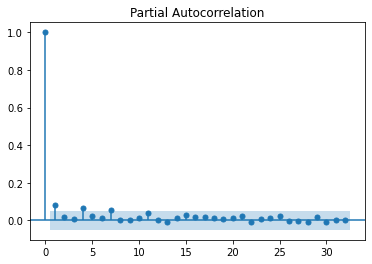

In [14]:
plot_pacf(btc_lrsq)
plt.show()

In [15]:
#Perhaps an arch 1 1 process will be useful

check fitnnes of model

In [16]:
model = arch_model(btc_logr, p=1, q=1, rescale=False)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 99752167.41624568
Iteration:      2,   Func. Count:     17,   Neg. LLF: -2594.772683070735
Iteration:      3,   Func. Count:     23,   Neg. LLF: 23702.703991733382
Iteration:      4,   Func. Count:     34,   Neg. LLF: -2472.2912933314637
Iteration:      5,   Func. Count:     41,   Neg. LLF: -2671.3767547147704
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2671.376753335094
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2671.38
Distribution:                  Normal   AIC:                          -5334.75
Method:            Maximum Likelihood   BIC:                          -5313.50
                                        No. Observations:                 1500
Date:                Mon, Nov 29 2021   Df Residuals:                     1496
Time:                        17:27:44   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.4473e-03  1.002e-03      2.443  1.458e-02 [4.836e-04,4.411e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.6666e-04  1.206e-04      1.382      0.167 [-6.972e-05,4.030e-04]
alpha[1]       0.0925  2.680e-02      3.452  5.569e-04    [3.998e-02,  0.145]
beta[1]        0.8177  7.490e-02     10.918  9.423e-28      [  0.671,  0.965]
=============================================================================

Covariance estimator: robust
"""

### looking at the residuals of the model

normal   -4231.719136
t         2836.640462
skewt     2836.640462
dtype: float64


/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/3555378299.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([pd.Series(std_resid), pd.Series(unit_var_resid)], 1)


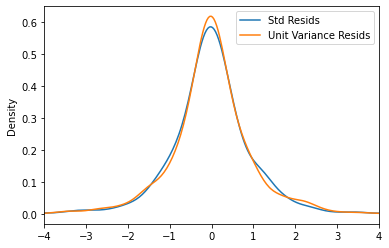

In [17]:
from collections import OrderedDict
res_normal = arch_model(100*btc_logr, rescale=False).fit(disp="off")
res_t = arch_model(btc_logr, dist="t", rescale=False).fit(disp="off")
res_skewt = arch_model(btc_logr, dist="skewt", rescale=False).fit(disp="off")
lls = pd.Series(
    OrderedDict(
        (
            ("normal", res_normal.loglikelihood),
            ("t", res_t.loglikelihood),
            ("skewt", res_skewt.loglikelihood),
        )
    )
)

print(lls)
params = pd.DataFrame(
    OrderedDict(
        (
            ("normal", res_normal.params),
            ("t", res_t.params),
            ("skewt", res_skewt.params),
        )
    )
)

std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([pd.Series(std_resid), pd.Series(unit_var_resid)], 1)
df.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

normal   -1695.152428
t         -351.384067
skewt    -5934.312258
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_19414/2512664064.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([pd.Series(std_resid), pd.Series(unit_var_resid)], 1)


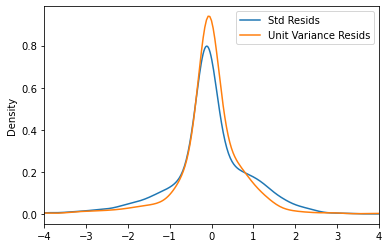

In [18]:
res_normal = arch_model(100*sp_logr, rescale=False).fit(disp="off")
res_t = arch_model(sp_logr, dist="t", rescale=False).fit(disp="off")
res_skewt = arch_model(sp_logr, dist="skewt", rescale=False).fit(disp="off")
lls = pd.Series(
    OrderedDict(
        (
            ("normal", res_normal.loglikelihood),
            ("t", res_t.loglikelihood),
            ("skewt", res_skewt.loglikelihood),
        )
    )
)

print(lls)
params = pd.DataFrame(
    OrderedDict(
        (
            ("normal", res_normal.params),
            ("t", res_t.params),
            ("skewt", res_skewt.params),
        )
    )
)

kstd_resid = res_normal.resid / res_normal.conditional_volatility
std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([pd.Series(std_resid), pd.Series(unit_var_resid)], 1)
df.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

In [19]:
bitcoin daily returns are more normal than 

SyntaxError: invalid syntax (520999880.py, line 1)

### compare parameters to model on S&P

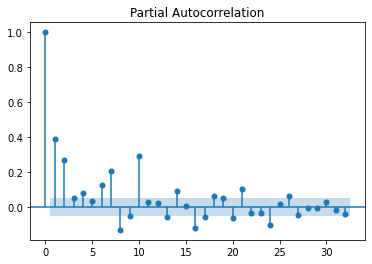

In [20]:
plot_pacf(sp_lrsq)
plt.show()

In [21]:
model = arch_model(sp_logr, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6.91533332312599e+21
Iteration:      2,   Func. Count:     23,   Neg. LLF: 219011879851.2007
Iteration:      3,   Func. Count:     37,   Neg. LLF: -5204.607265160714
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5204.607263173953
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 3


/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/arch/univariate/base.py:259: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(data_scale_warning.format(orig_scale, rescale),


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                5204.61
Distribution:                  Normal   AIC:                          -10397.2
Method:            Maximum Likelihood   BIC:                          -10365.3
                                        No. Observations:                 1500
Date:                Mon, Nov 29 2021   Df Residuals:                     1494
Time:                        17:27:48   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.0605e-04  3.509e-07   2297.101      0.000 [8.054e-04,8.067e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.3927e-06  1.055e-12  2.269e+06      0.000 [2.393e-06,2.393e-06]
alpha[1]       0.1000  4.082e-02      2.450  1.429e-02   [2.000e-02,  0.180]
alpha[2]       0.1000  7.893e-02      1.267      0.205  [-5.470e-02,  0.255]
beta[1]        0.3900      0.583      0.668      0.504     [ -0.753,  1.533]
beta[2]        0.3900      0.524      0.745      0.457     [ -0.637,  1.417]
============================================================================

Covariance estimator: robust
"""

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


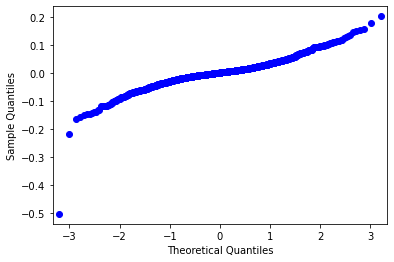

In [29]:

import statsmodels.api as sm
import pylab
from scipy.stats.distributions import norm

sm.qqplot(btc_logr,norm)
pylab.show()

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


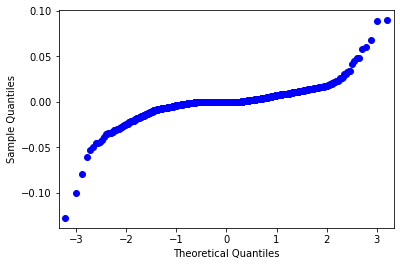

In [28]:
sm.qqplot(sp_logr,norm)
pylab.show()

In [ ]:
compare to weekly sp distribution

In [ ]:
https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html